In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Deep Learning**

###Library

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, Dense, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/Opu/Emotion.csv")

In [ ]:
df.head()

,ID,Data,Love,Joy,Surprise,Anger,Sadness,Fear,Disgust,Hate,Topic,Domain,is_admin
0,5454.0,লকাল বাস ভালো এটা থেকে,0,0,0.0,0,1,0,0.0,0,Travel,Youtube,False
1,22549.0,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,0,0,0.0,0,1,0,0.0,0,Politics,Youtube,False
2,7033.0,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,0,0,0.0,1,0,0,0.0,0,Personal,Facebook,False
3,21114.0,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,0,0,0.0,0,1,0,0.0,0,Education,Facebook,False
4,23683.0,সত্যিকার মানুষ তারাই ভাই,0,1,0.0,0,0,0,0.0,0,Personal,Youtube,False


In [ ]:
df.drop(columns=['ID', 'Topic', 'Domain', 'is_admin'], inplace=True)

In [ ]:
df.head()

,Data,Love,Joy,Surprise,Anger,Sadness,Fear,Disgust,Hate
0,লকাল বাস ভালো এটা থেকে,0,0,0.0,0,1,0,0.0,0
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,0,0,0.0,0,1,0,0.0,0
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,0,0,0.0,1,0,0,0.0,0
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,0,0,0.0,0,1,0,0.0,0
4,সত্যিকার মানুষ তারাই ভাই,0,1,0.0,0,0,0,0.0,0


In [ ]:
for column in df.columns[1:-1]:
    count = (df[column] == 1).sum()
    print(f"{column}: {count}")

Love: 4588
Joy: 10112
Surprise: 1086
Anger: 4476
Sadness: 5681
Fear: 401
Disgust: 2068


In [ ]:
rows_to_remove = []
df['label'] = None
for index, row in df.iterrows():
    count_ones = 0
    label = None
    for column in df.columns[1:]:
        if row[column] == 1:
            count_ones += 1
            label = column
            if count_ones > 1:
                rows_to_remove.append(index)
                break
    df.loc[index, 'label'] = label

df.drop(rows_to_remove, inplace=True)

In [ ]:
df.head()

,Data,Love,Joy,Surprise,Anger,Sadness,Fear,Disgust,Hate,label
0,লকাল বাস ভালো এটা থেকে,0,0,0.0,0,1,0,0.0,0,Sadness
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,0,0,0.0,0,1,0,0.0,0,Sadness
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,0,0,0.0,1,0,0,0.0,0,Anger
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,0,0,0.0,0,1,0,0.0,0,Sadness
4,সত্যিকার মানুষ তারাই ভাই,0,1,0.0,0,0,0,0.0,0,Joy


In [ ]:
df['label'].value_counts()

label
Joy         7669
Sadness     4856
Anger       3435
Love        2279
Disgust     2068
Hate        1591
Surprise     744
Fear         233
Name: count, dtype: int64

In [ ]:
print('Total Data : ', df['Data'].shape)
print('Total Label : ', df['label'].shape)

Total Data :  (22875,)
Total Label :  (22875,)


####**Remove Unnecessary column**

In [ ]:
df.drop(columns=['Love', 'Joy', 'Surprise', 'Anger','Sadness','Fear','Disgust','Hate'], inplace=True)

In [ ]:
df.head()

,Data,label
0,লকাল বাস ভালো এটা থেকে,Sadness
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,Sadness
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,Anger
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,Sadness
4,সত্যিকার মানুষ তারাই ভাই,Joy


In [ ]:
df['label'].unique()

array(['Sadness', 'Anger', 'Joy', 'Love', 'Surprise', 'Fear', 'Disgust',
       'Hate'], dtype=object)

In [ ]:
import string
import re
def preprocess_text(text):

    text = re.sub('<[^<]+?>', '', text)
    text = re.sub(r'http\S+', '', text)
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = ' '.join([word for word in text.split() if len(word) > 1])
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

df['Data'] = df['Data'].apply(lambda x: preprocess_text(x) if pd.notnull(x) else x)
print(df.head())

                                                Data    label
0                             লকাল বাস ভালো এটা থেকে  Sadness
1  কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...  Sadness
2  বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান নং ...    Anger
3                   চাচাজি তো কেবল মাকে ধর্ষণ করেছেন  Sadness
4                           সত্যিকার মানুষ তারাই ভাই      Joy


In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['Data'] = df['Data'].apply(remove_emoji)
df.head()

,Data,label
0,লকাল বাস ভালো এটা থেকে,Sadness
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,Sadness
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান নং ...,Anger
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,Sadness
4,সত্যিকার মানুষ তারাই ভাই,Joy


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Data'])
vocab_size = len(tokenizer.word_index) + 1
max_sequence_length = max([len(x.split()) for x in df['Data']])

print("Vocabulary size:", vocab_size)
print("Max sequence length:", max_sequence_length)

Vocabulary size: 39880
Max sequence length: 250


###Dependent

In [ ]:
X = df['Data']
y = df['label']

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(18300,) (4575,) (18300,) (4575,)


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

max_sequence_length = max_sequence_length
X_train_padded = pad_sequences(X_train_tokenized, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_tokenized, maxlen=max_sequence_length, padding='post')

####Performance Function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder

def evaluate_model(model, X_test, y_test, history, label_encoder):
    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Inverse transform encoded labels to actual labels
    y_test_actual = label_encoder.inverse_transform(y_test)
    y_pred_actual = label_encoder.inverse_transform(y_pred)

    # Accuracy
    accuracy = accuracy_score(y_test_actual, y_pred_actual)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test_actual, y_pred_actual, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test_actual, y_pred_actual, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test_actual, y_pred_actual, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test_actual, y_pred_actual))

    # Confusion Matrix
    cm = confusion_matrix(y_test_actual, y_pred_actual)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = label_encoder.classes_
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
embedding_dim = 128
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 128)          5104640   
                                                                 
 conv1d (Conv1D)             (None, 246, 128)          82048     
                                                                 
 max_pooling1d (MaxPooling1  (None, 123, 128)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 15744)             0         
                                                                 
 dense (Dense)               (None, 64)                1007680   
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                        

In [ ]:
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_data=(X_test_padded, y_test))

Epoch 1/10
286/286 [==============================] - 24s 67ms/step - loss: 1.4563 - accuracy: 0.4564 - val_loss: 1.2207 - val_accuracy: 0.5545
Epoch 2/10
286/286 [==============================] - 6s 22ms/step - loss: 0.9223 - accuracy: 0.6714 - val_loss: 1.1476 - val_accuracy: 0.6107
Epoch 3/10
286/286 [==============================] - 5s 19ms/step - loss: 0.5042 - accuracy: 0.8269 - val_loss: 1.3784 - val_accuracy: 0.5963
Epoch 4/10
286/286 [==============================] - 4s 13ms/step - loss: 0.2566 - accuracy: 0.9140 - val_loss: 1.7752 - val_accuracy: 0.5624
Epoch 5/10
286/286 [==============================] - 4s 12ms/step - loss: 0.1307 - accuracy: 0.9582 - val_loss: 2.0375 - val_accuracy: 0.5672
Epoch 6/10
286/286 [==============================] - 4s 15ms/step - loss: 0.0702 - accuracy: 0.9785 - val_loss: 2.2885 - val_accuracy: 0.5604
Epoch 7/10
286/286 [==============================] - 3s 10ms/step - loss: 0.0413 - accuracy: 0.9878 - val_loss: 2.6160 - val_accuracy: 0.560

143/143 [==============================] - 1s 3ms/step
Accuracy: 0.5504
Precision: 0.5632
Recall: 0.5504
F1-Score: 0.5543


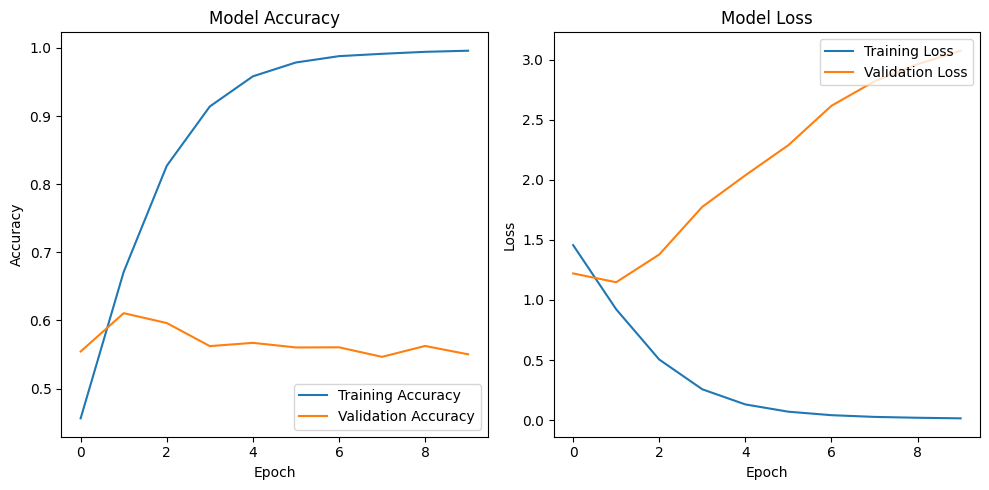

Classification Report:
              precision    recall  f1-score   support

       Anger       0.41      0.52      0.46       711
     Disgust       0.43      0.32      0.36       395
        Fear       0.07      0.07      0.07        45
        Hate       0.89      0.73      0.80       305
         Joy       0.69      0.65      0.67      1593
        Love       0.40      0.42      0.41       462
     Sadness       0.58      0.58      0.58       928
    Surprise       0.14      0.18      0.16       136

    accuracy                           0.55      4575
   macro avg       0.45      0.43      0.44      4575
weighted avg       0.56      0.55      0.55      4575



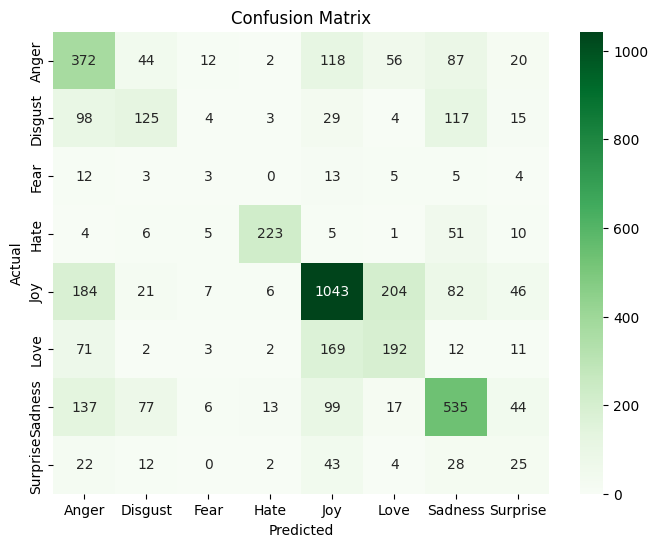

In [ ]:
evaluate_model(model, X_test_padded, y_test, history, label_encoder)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_test = np.expand_dims(X_test, axis=1)
y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'conv1d' (type Conv1D).
    
    Negative dimension size caused by subtracting 5 from 1 for '{{node sequential/conv1d/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential/conv1d/Conv1D/ExpandDims, sequential/conv1d/Conv1D/ExpandDims_1)' with input shapes: [?,1,1,128], [1,5,128,128].
    
    Call arguments received by layer 'conv1d' (type Conv1D):
      • inputs=tf.Tensor(shape=(None, 1, 128), dtype=float32)


In [ ]:
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_data=(X_test_padded, y_test))

Epoch 1/10
286/286 [==============================] - 24s 71ms/step - loss: 1.4824 - accuracy: 0.4483 - val_loss: 1.1801 - val_accuracy: 0.5639
Epoch 2/10
286/286 [==============================] - 8s 28ms/step - loss: 0.9336 - accuracy: 0.6629 - val_loss: 1.1312 - val_accuracy: 0.6105
Epoch 3/10
286/286 [==============================] - 5s 18ms/step - loss: 0.5068 - accuracy: 0.8307 - val_loss: 1.3905 - val_accuracy: 0.6017
Epoch 4/10
286/286 [==============================] - 4s 12ms/step - loss: 0.2433 - accuracy: 0.9230 - val_loss: 1.6912 - val_accuracy: 0.5882
Epoch 5/10
286/286 [==============================] - 4s 12ms/step - loss: 0.1138 - accuracy: 0.9652 - val_loss: 2.0745 - val_accuracy: 0.5642
Epoch 6/10
286/286 [==============================] - 5s 16ms/step - loss: 0.0627 - accuracy: 0.9815 - val_loss: 2.4051 - val_accuracy: 0.5637
Epoch 7/10
286/286 [==============================] - 3s 11ms/step - loss: 0.0365 - accuracy: 0.9890 - val_loss: 2.7673 - val_accuracy: 0.555

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve

def evaluate_model(model, X_test, y_test, history):
    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

165/165 [==============================] - 0s 3ms/step
Accuracy: 0.5032
Precision: 0.5155
Recall: 0.5032
F1-Score: 0.5085


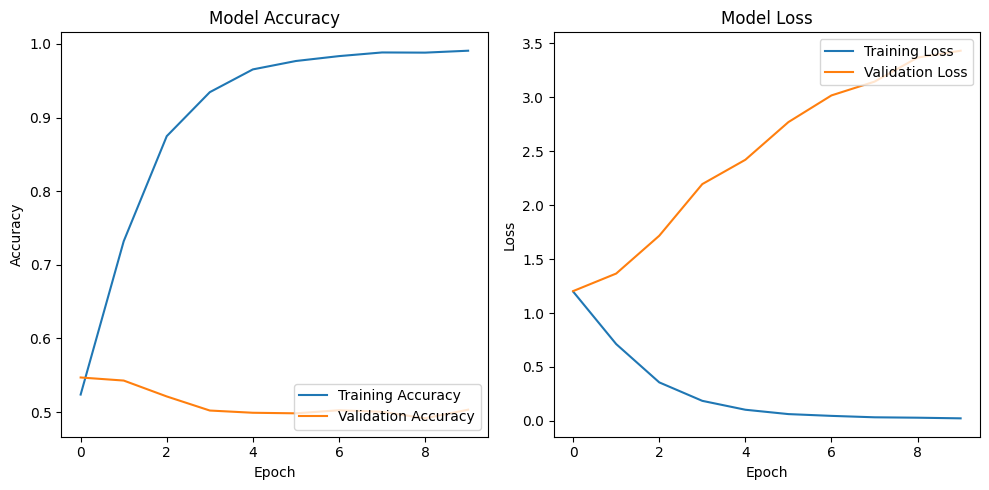

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.44      0.44       827
           1       0.38      0.37      0.37       404
           2       0.06      0.09      0.07        47
           3       0.82      0.71      0.76       297
           4       0.57      0.55      0.56      1625
           5       0.47      0.49      0.48       931
           6       0.58      0.55      0.57       965
           7       0.17      0.27      0.21       184

    accuracy                           0.50      5280
   macro avg       0.44      0.43      0.43      5280
weighted avg       0.52      0.50      0.51      5280



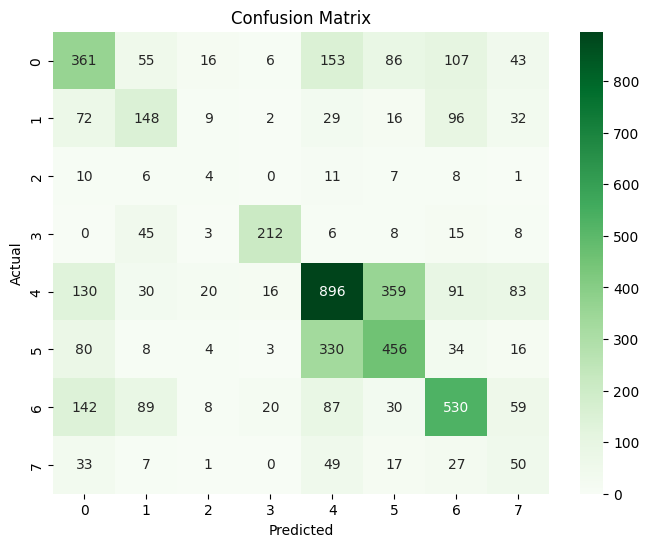

In [ ]:
evaluate_model(model, X_test_padded, y_test, history)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder

def evaluate_model(model, X_test, y_test, history, label_encoder):
    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Inverse transform encoded labels to actual labels
    y_test_actual = label_encoder.inverse_transform(y_test)
    y_pred_actual = label_encoder.inverse_transform(y_pred)

    # Accuracy
    accuracy = accuracy_score(y_test_actual, y_pred_actual)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test_actual, y_pred_actual, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test_actual, y_pred_actual, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test_actual, y_pred_actual, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test_actual, y_pred_actual))

    # Confusion Matrix
    cm = confusion_matrix(y_test_actual, y_pred_actual)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = label_encoder.classes_
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

143/143 [==============================] - 1s 3ms/step
Accuracy: 0.5532
Precision: 0.5758
Recall: 0.5532
F1-Score: 0.5616


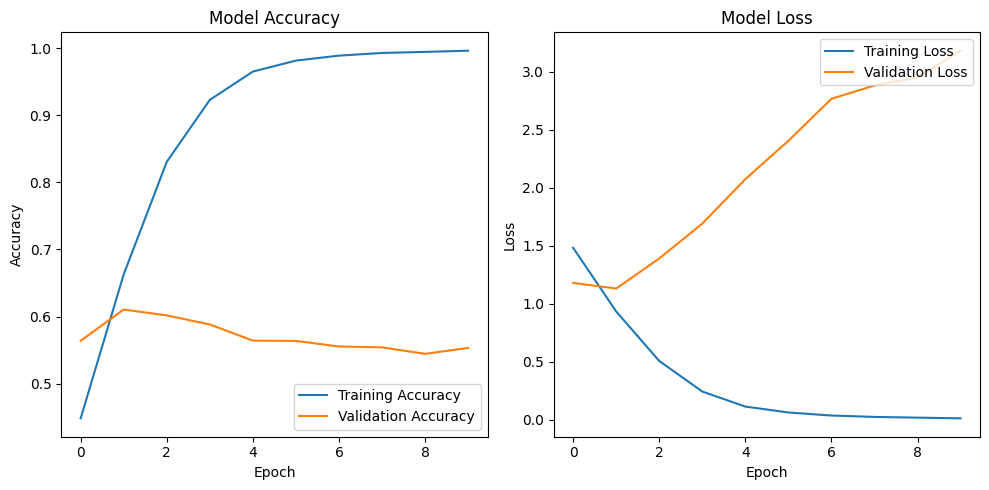

Classification Report:
              precision    recall  f1-score   support

       Anger       0.45      0.50      0.48       711
     Disgust       0.41      0.42      0.41       395
        Fear       0.07      0.07      0.07        45
        Hate       0.94      0.66      0.78       305
         Joy       0.67      0.68      0.67      1593
        Love       0.44      0.36      0.40       462
     Sadness       0.62      0.57      0.59       928
    Surprise       0.10      0.21      0.14       136

    accuracy                           0.55      4575
   macro avg       0.46      0.43      0.44      4575
weighted avg       0.58      0.55      0.56      4575



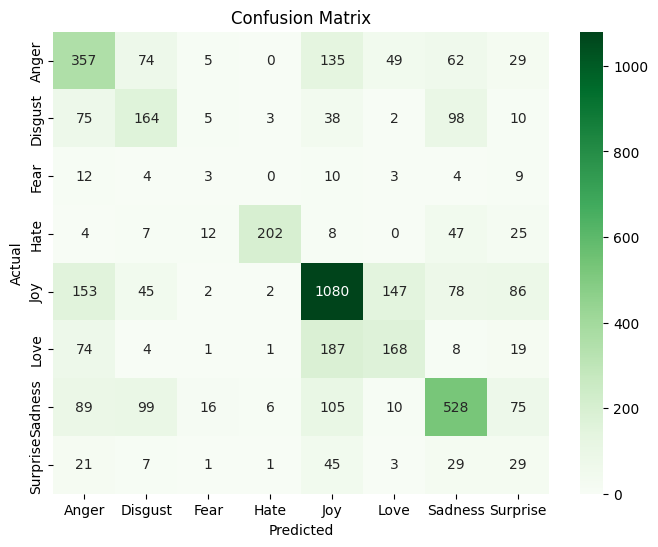

In [ ]:
evaluate_model(model, X_test_padded, y_test, history, label_encoder)

####**Using L2 Regularizer**

In [ ]:
from keras.regularizers import l2

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 128)          5551232   
                                                                 
 conv1d_2 (Conv1D)           (None, 246, 128)          82048     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 123, 128)          0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 15744)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                1007680   
                                                                 
 dense_3 (Dense)             (None, 8)                 520       
                                                      

In [ ]:
history = model.fit(X_train_padded, y_train, epochs=20, batch_size=64, validation_data=(X_test_padded, y_test))

Epoch 1/20
330/330 [==============================] - 23s 63ms/step - loss: 1.8033 - accuracy: 0.3694 - val_loss: 1.5334 - val_accuracy: 0.4331
Epoch 2/20
330/330 [==============================] - 8s 26ms/step - loss: 1.4029 - accuracy: 0.4824 - val_loss: 1.4665 - val_accuracy: 0.4511
Epoch 3/20
330/330 [==============================] - 5s 15ms/step - loss: 1.2392 - accuracy: 0.5583 - val_loss: 1.5126 - val_accuracy: 0.4629
Epoch 4/20
330/330 [==============================] - 5s 14ms/step - loss: 1.1165 - accuracy: 0.6211 - val_loss: 1.5637 - val_accuracy: 0.4653
Epoch 5/20
330/330 [==============================] - 4s 11ms/step - loss: 1.0092 - accuracy: 0.6813 - val_loss: 1.6457 - val_accuracy: 0.4777
Epoch 6/20
330/330 [==============================] - 3s 9ms/step - loss: 0.8991 - accuracy: 0.7445 - val_loss: 1.7424 - val_accuracy: 0.4920
Epoch 7/20
330/330 [==============================] - 3s 10ms/step - loss: 0.7881 - accuracy: 0.7938 - val_loss: 1.8612 - val_accuracy: 0.4884

In [ ]:
evaluate_model(model, X_test_padded, y_test, history)

####**Using LR**

#####**57 Acc**

In [ ]:
from tensorflow.keras.optimizers import Adam
embedding_dim = 128
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax'))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 conv1d_2 (Conv1D)           (None, 246, 128)          82048     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 123, 128)          0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 15744)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                1007680   
                                                                 
 dense_5 (Dense)             (None, 8)                 520       
                                                      

In [ ]:
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_data=(X_test_padded, y_test))

Epoch 1/10
286/286 [==============================] - 25s 79ms/step - loss: 1.4595 - accuracy: 0.4586 - val_loss: 1.1926 - val_accuracy: 0.5569
Epoch 2/10
286/286 [==============================] - 8s 28ms/step - loss: 0.9263 - accuracy: 0.6661 - val_loss: 1.1365 - val_accuracy: 0.6048
Epoch 3/10
286/286 [==============================] - 5s 17ms/step - loss: 0.4787 - accuracy: 0.8353 - val_loss: 1.3376 - val_accuracy: 0.6024
Epoch 4/10
286/286 [==============================] - 4s 15ms/step - loss: 0.2202 - accuracy: 0.9270 - val_loss: 1.6756 - val_accuracy: 0.5792
Epoch 5/10
286/286 [==============================] - 4s 13ms/step - loss: 0.1066 - accuracy: 0.9660 - val_loss: 2.0241 - val_accuracy: 0.5694
Epoch 6/10
286/286 [==============================] - 3s 12ms/step - loss: 0.0535 - accuracy: 0.9837 - val_loss: 2.2595 - val_accuracy: 0.5779
Epoch 7/10
286/286 [==============================] - 3s 11ms/step - loss: 0.0306 - accuracy: 0.9914 - val_loss: 2.4838 - val_accuracy: 0.576

143/143 [==============================] - 1s 3ms/step
Accuracy: 0.5718
Precision: 0.5790
Recall: 0.5718
F1-Score: 0.5731


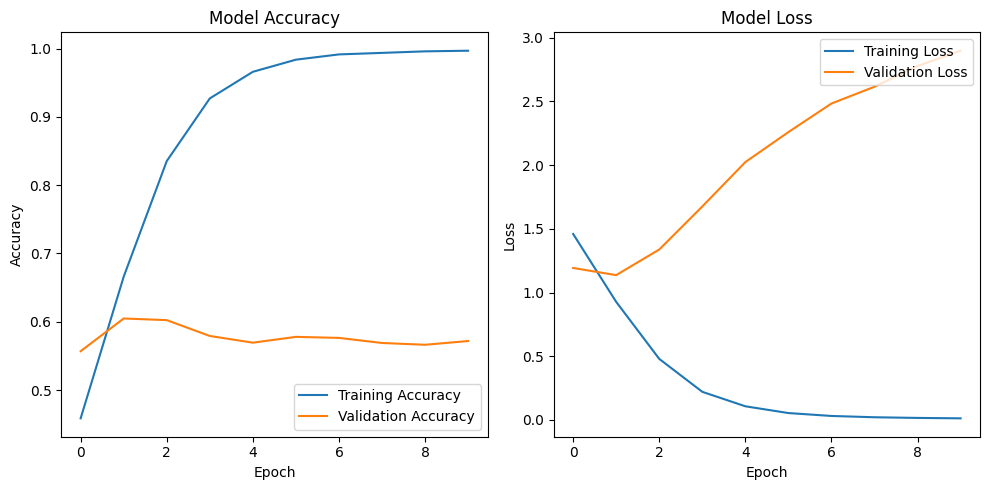

Classification Report:
              precision    recall  f1-score   support

       Anger       0.50      0.47      0.49       711
     Disgust       0.46      0.37      0.41       395
        Fear       0.02      0.02      0.02        45
        Hate       0.90      0.77      0.83       305
         Joy       0.65      0.72      0.68      1593
        Love       0.41      0.43      0.42       462
     Sadness       0.64      0.56      0.60       928
    Surprise       0.14      0.21      0.17       136

    accuracy                           0.57      4575
   macro avg       0.47      0.44      0.45      4575
weighted avg       0.58      0.57      0.57      4575



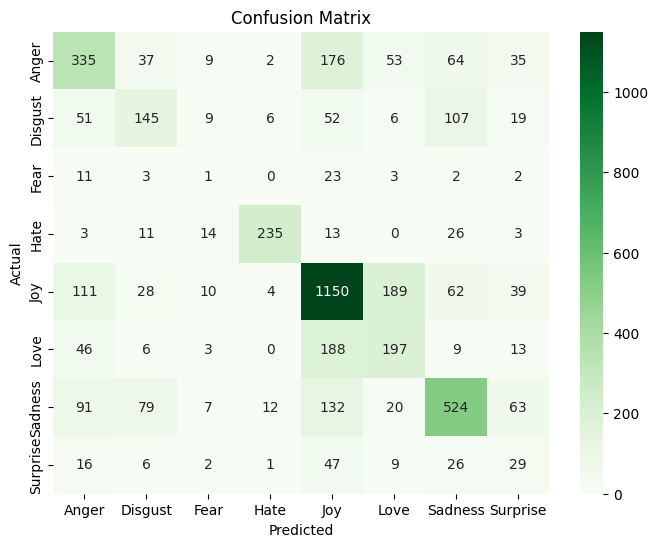

In [ ]:
evaluate_model(model, X_test_padded, y_test, history, label_encoder)

In [ ]:
embedding_dim = 128
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax'))

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 conv1d_3 (Conv1D)           (None, 246, 128)          82048     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 123, 128)          0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 15744)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                1007680   
                                                                 
 dense_7 (Dense)             (None, 8)                 520       
                                                      

In [ ]:
history = model.fit(X_train_padded, y_train, epochs=20, batch_size=64, validation_data=(X_test_padded, y_test))

Epoch 1/20
286/286 [==============================] - 23s 71ms/step - loss: 1.7598 - accuracy: 0.3378 - val_loss: 1.6849 - val_accuracy: 0.3661
Epoch 2/20
286/286 [==============================] - 10s 34ms/step - loss: 1.6362 - accuracy: 0.3988 - val_loss: 1.5529 - val_accuracy: 0.4284
Epoch 3/20
286/286 [==============================] - 5s 17ms/step - loss: 1.4536 - accuracy: 0.4775 - val_loss: 1.4474 - val_accuracy: 0.4689
Epoch 4/20
286/286 [==============================] - 5s 18ms/step - loss: 1.2890 - accuracy: 0.5256 - val_loss: 1.3927 - val_accuracy: 0.4903
Epoch 5/20
286/286 [==============================] - 6s 20ms/step - loss: 1.1519 - accuracy: 0.5838 - val_loss: 1.3773 - val_accuracy: 0.4992
Epoch 6/20
286/286 [==============================] - 3s 11ms/step - loss: 1.0282 - accuracy: 0.6308 - val_loss: 1.3799 - val_accuracy: 0.5095
Epoch 7/20
286/286 [==============================] - 4s 14ms/step - loss: 0.8974 - accuracy: 0.6946 - val_loss: 1.3891 - val_accuracy: 0.53

143/143 [==============================] - 1s 6ms/step
Accuracy: 0.5211
Precision: 0.5285
Recall: 0.5211
F1-Score: 0.5226


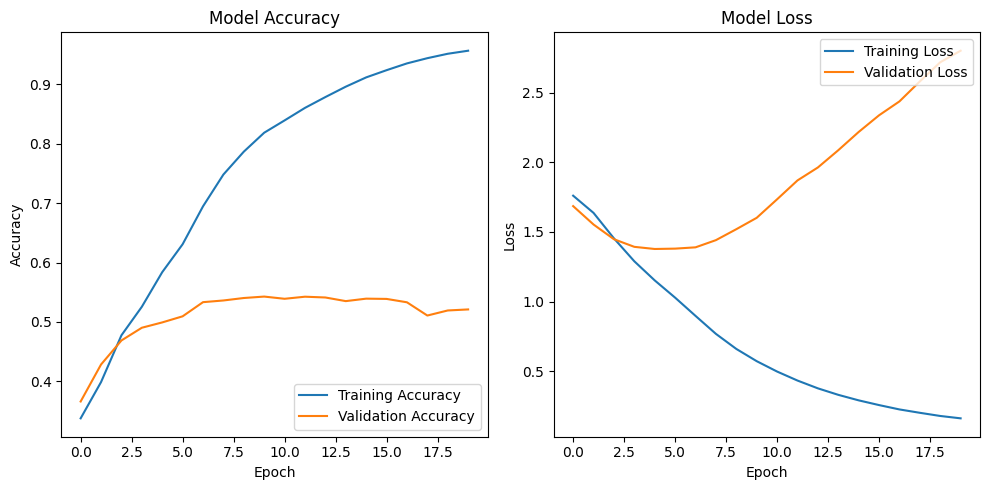

Classification Report:
              precision    recall  f1-score   support

       Anger       0.35      0.41      0.38       711
     Disgust       0.40      0.33      0.36       395
        Fear       0.07      0.02      0.03        45
        Hate       0.89      0.71      0.79       305
         Joy       0.65      0.68      0.66      1593
        Love       0.35      0.40      0.37       462
     Sadness       0.57      0.51      0.54       928
    Surprise       0.04      0.04      0.04       136

    accuracy                           0.52      4575
   macro avg       0.42      0.39      0.40      4575
weighted avg       0.53      0.52      0.52      4575



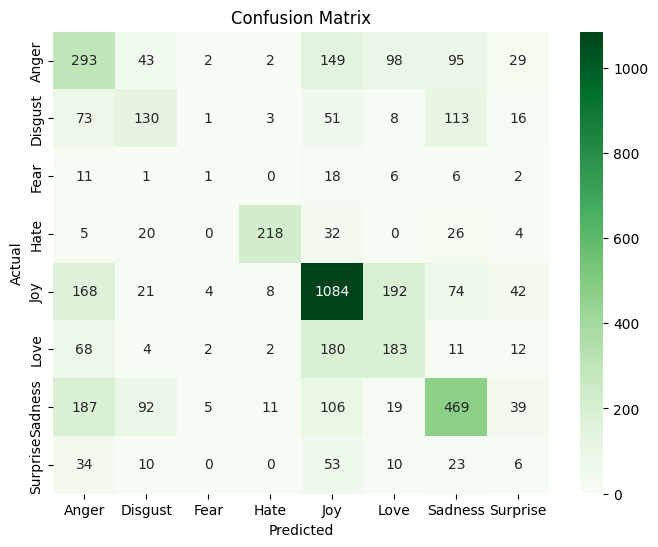

In [ ]:
evaluate_model(model, X_test_padded, y_test, history, label_encoder)

In [ ]:
from keras.regularizers import l2
embedding_dim = 128
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(8, activation='softmax', kernel_regularizer=l2(0.01)))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 conv1d_4 (Conv1D)           (None, 246, 128)          82048     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 123, 128)          0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 15744)             0         
                                                                 
 dense_8 (Dense)             (None, 64)                1007680   
                                                                 
 dense_9 (Dense)             (None, 8)                 520       
                                                      

In [ ]:
history = model.fit(X_train_padded, y_train, epochs=20, batch_size=64, validation_data=(X_test_padded, y_test))

Epoch 1/20
286/286 [==============================] - 28s 90ms/step - loss: 1.8859 - accuracy: 0.4097 - val_loss: 1.5395 - val_accuracy: 0.4833
Epoch 2/20
286/286 [==============================] - 8s 30ms/step - loss: 1.4382 - accuracy: 0.5234 - val_loss: 1.4882 - val_accuracy: 0.5132
Epoch 3/20
286/286 [==============================] - 7s 24ms/step - loss: 1.2820 - accuracy: 0.5979 - val_loss: 1.5622 - val_accuracy: 0.5008
Epoch 4/20
286/286 [==============================] - 4s 14ms/step - loss: 1.1803 - accuracy: 0.6511 - val_loss: 1.5813 - val_accuracy: 0.5139
Epoch 5/20
286/286 [==============================] - 4s 13ms/step - loss: 1.1048 - accuracy: 0.6938 - val_loss: 1.6835 - val_accuracy: 0.5047
Epoch 6/20
286/286 [==============================] - 4s 13ms/step - loss: 1.0461 - accuracy: 0.7173 - val_loss: 1.7806 - val_accuracy: 0.4949
Epoch 7/20
286/286 [==============================] - 3s 12ms/step - loss: 0.9994 - accuracy: 0.7342 - val_loss: 1.8508 - val_accuracy: 0.495

143/143 [==============================] - 1s 4ms/step
Accuracy: 0.4695
Precision: 0.4798
Recall: 0.4695


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1-Score: 0.4695


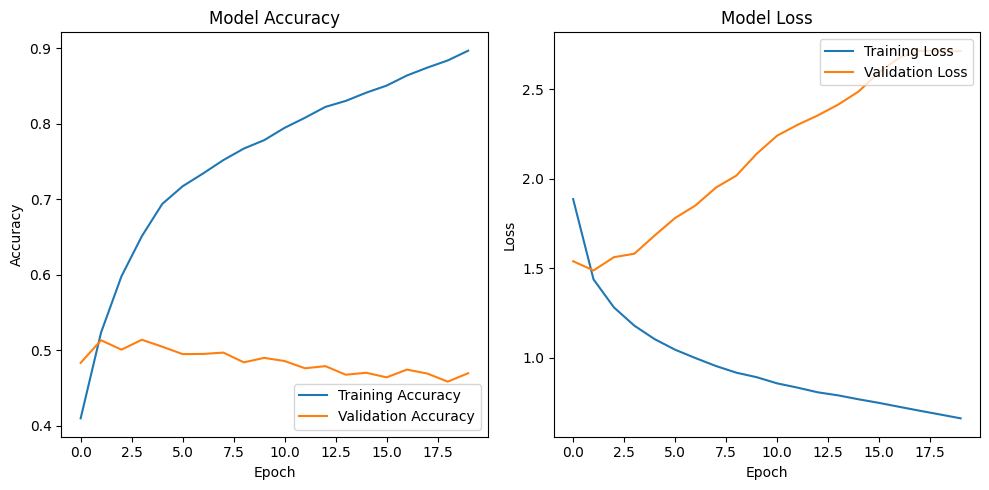

Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Anger       0.28      0.44      0.34       711
     Disgust       0.37      0.25      0.30       395
        Fear       0.00      0.00      0.00        45
        Hate       0.79      0.59      0.67       305
         Joy       0.67      0.66      0.66      1593
        Love       0.25      0.23      0.24       462
     Sadness       0.45      0.43      0.44       928
    Surprise       0.07      0.04      0.05       136

    accuracy                           0.47      4575
   macro avg       0.36      0.33      0.34      4575
weighted avg       0.48      0.47      0.47      4575



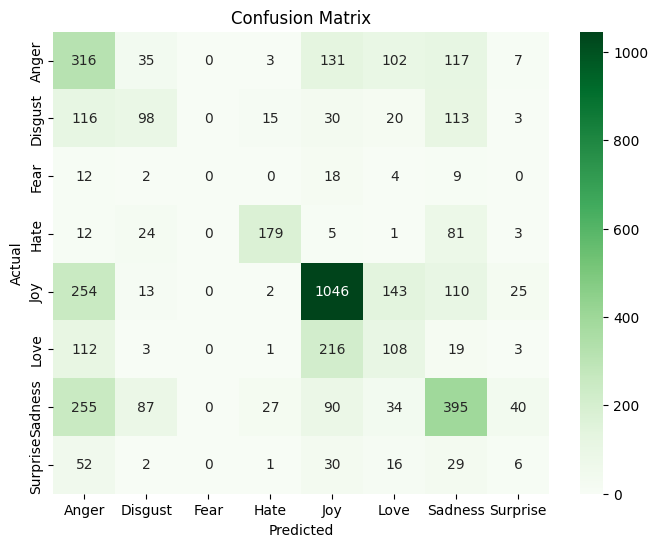

In [ ]:
evaluate_model(model, X_test_padded, y_test, history, label_encoder)

In [ ]:
embedding_dim = 128

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='softmax'))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 conv1d_5 (Conv1D)           (None, 246, 128)          82048     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 123, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 121, 64)           24640     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 60, 64)            0         
 g1D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 3840)             

In [ ]:
history = model.fit(X_train_padded, y_train, epochs=20, batch_size=64, validation_data=(X_test_padded, y_test))

Epoch 1/20
286/286 [==============================] - 32s 100ms/step - loss: 1.5846 - accuracy: 0.4145 - val_loss: 1.3946 - val_accuracy: 0.4765
Epoch 2/20
286/286 [==============================] - 8s 30ms/step - loss: 1.1909 - accuracy: 0.5521 - val_loss: 1.2786 - val_accuracy: 0.5351
Epoch 3/20
286/286 [==============================] - 6s 21ms/step - loss: 0.8648 - accuracy: 0.6773 - val_loss: 1.3732 - val_accuracy: 0.5489
Epoch 4/20
286/286 [==============================] - 5s 16ms/step - loss: 0.6004 - accuracy: 0.7795 - val_loss: 1.5516 - val_accuracy: 0.5342
Epoch 5/20
286/286 [==============================] - 4s 15ms/step - loss: 0.3802 - accuracy: 0.8678 - val_loss: 1.7859 - val_accuracy: 0.5375
Epoch 6/20
286/286 [==============================] - 4s 14ms/step - loss: 0.2287 - accuracy: 0.9242 - val_loss: 2.1086 - val_accuracy: 0.5351
Epoch 7/20
286/286 [==============================] - 4s 15ms/step - loss: 0.1243 - accuracy: 0.9596 - val_loss: 2.5857 - val_accuracy: 0.50

143/143 [==============================] - 1s 4ms/step
Accuracy: 0.5169
Precision: 0.5495
Recall: 0.5169
F1-Score: 0.5301


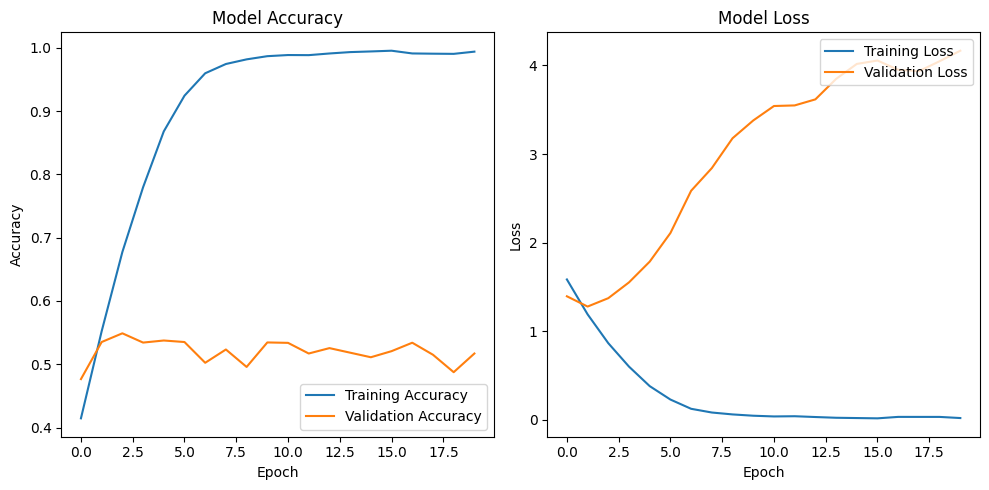

Classification Report:
              precision    recall  f1-score   support

       Anger       0.43      0.43      0.43       711
     Disgust       0.39      0.33      0.35       395
        Fear       0.15      0.07      0.09        45
        Hate       0.86      0.73      0.79       305
         Joy       0.68      0.63      0.66      1593
        Love       0.33      0.40      0.36       462
     Sadness       0.58      0.51      0.55       928
    Surprise       0.10      0.28      0.15       136

    accuracy                           0.52      4575
   macro avg       0.44      0.42      0.42      4575
weighted avg       0.55      0.52      0.53      4575



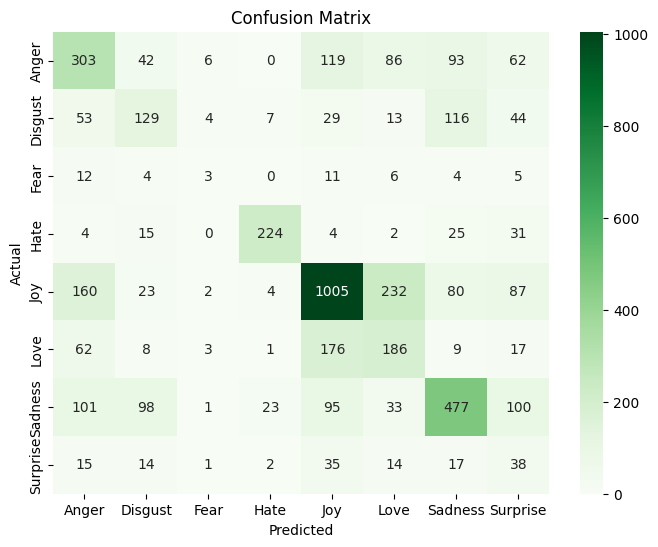

In [ ]:
evaluate_model(model, X_test_padded, y_test, history, label_encoder)

#####**last epoch 55 Acc and best 60**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
embedding_dim = 128
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax'))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Model/Opu/CNN/best_model.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 128)          5104640   
                                                                 
 conv1d (Conv1D)             (None, 246, 128)          82048     
                                                                 
 max_pooling1d (MaxPooling1  (None, 123, 128)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 15744)             0         
                                                                 
 dense (Dense)               (None, 64)                1007680   
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                        

In [ ]:
history = model.fit(X_train_padded, y_train, epochs=50, batch_size=64, validation_data=(X_test_padded, y_test), callbacks=[checkpoint])

Epoch 1/50
286/286 [==============================] - ETA: 0s - loss: 1.4709 - accuracy: 0.4573
Epoch 1: val_accuracy improved from -inf to 0.53508, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 31s 88ms/step - loss: 1.4709 - accuracy: 0.4573 - val_loss: 1.2536 - val_accuracy: 0.5351
Epoch 2/50
282/286 [============================>.] - ETA: 0s - loss: 0.9029 - accuracy: 0.6789
Epoch 2: val_accuracy improved from 0.53508 to 0.60918, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model.h5
286/286 [==============================] - 8s 28ms/step - loss: 0.9031 - accuracy: 0.6789 - val_loss: 1.1378 - val_accuracy: 0.6092
Epoch 3/50
285/286 [============================>.] - ETA: 0s - loss: 0.4385 - accuracy: 0.8539
Epoch 3: val_accuracy did not improve from 0.60918
286/286 [==============================] - 5s 18ms/step - loss: 0.4379 - accuracy: 0.8541 - val_loss: 1.4208 - val_accuracy: 0.5812
Epoch 4/50
284/286 [============================>.] - ETA: 0s - loss: 0.1840 - accuracy: 0.9435
Epoch 4: val_accuracy did not improve from 0.60918
286/286 [==============================] - 4s 13ms/step - loss: 0.1842 - accuracy: 0.9434 

143/143 [==============================] - 0s 2ms/step
Accuracy: 0.5567
Precision: 0.5613
Recall: 0.5567
F1-Score: 0.5583


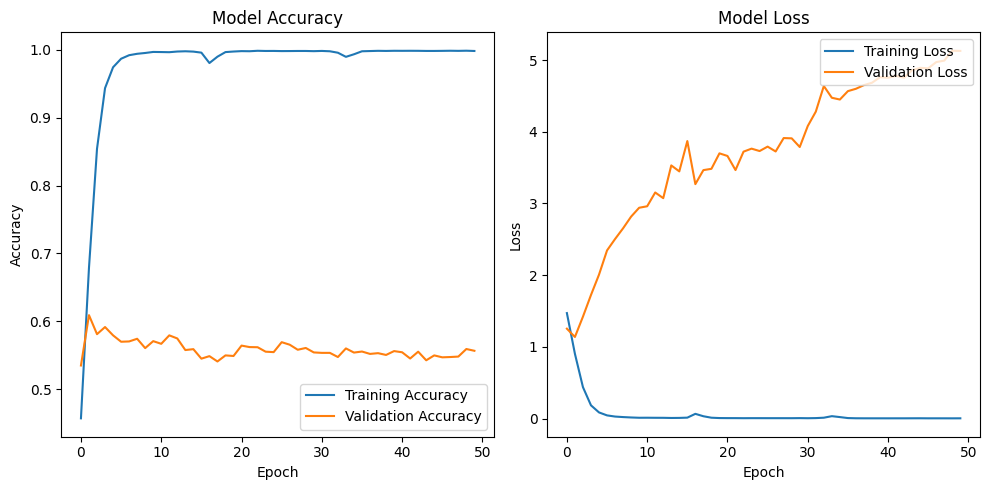

Classification Report:
              precision    recall  f1-score   support

       Anger       0.47      0.51      0.49       711
     Disgust       0.39      0.39      0.39       395
        Fear       0.05      0.04      0.05        45
        Hate       0.85      0.79      0.81       305
         Joy       0.66      0.68      0.67      1593
        Love       0.37      0.39      0.38       462
     Sadness       0.61      0.55      0.58       928
    Surprise       0.16      0.18      0.17       136

    accuracy                           0.56      4575
   macro avg       0.45      0.44      0.44      4575
weighted avg       0.56      0.56      0.56      4575



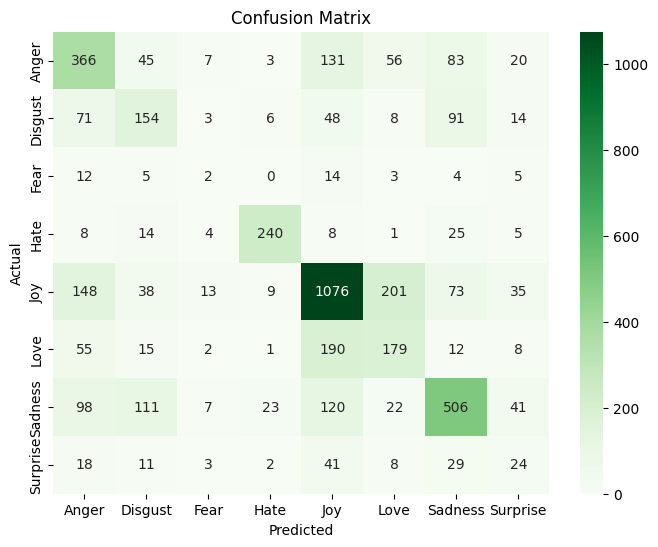

In [ ]:
evaluate_model(model, X_test_padded, y_test, history, label_encoder)

#####**last epoch 56 Acc and best 60**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
embedding_dim = 128
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(8, activation='softmax'))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Model/Opu/CNN/best_model_new.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 conv1d_2 (Conv1D)           (None, 248, 64)           24640     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 124, 64)           0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 7936)              0         
                                                                 
 dense_4 (Dense)             (None, 8)                 63496     
                                                                 
Total params: 5192776 (19.81 MB)
Trainable params: 5192776 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [ ]:
history = model.fit(X_train_padded, y_train, epochs=50, batch_size=64, validation_data=(X_test_padded, y_test), callbacks=[checkpoint])

Epoch 1/50
286/286 [==============================] - ETA: 0s - loss: 1.5172 - accuracy: 0.4343
Epoch 1: val_accuracy improved from -inf to 0.55585, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new.h5
286/286 [==============================] - 20s 66ms/step - loss: 1.5172 - accuracy: 0.4343 - val_loss: 1.2061 - val_accuracy: 0.5558
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


279/286 [============================>.] - ETA: 0s - loss: 0.9467 - accuracy: 0.6635
Epoch 2: val_accuracy improved from 0.55585 to 0.60568, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new.h5
286/286 [==============================] - 7s 26ms/step - loss: 0.9465 - accuracy: 0.6631 - val_loss: 1.1190 - val_accuracy: 0.6057
Epoch 3/50
284/286 [============================>.] - ETA: 0s - loss: 0.5047 - accuracy: 0.8321
Epoch 3: val_accuracy did not improve from 0.60568
286/286 [==============================] - 5s 16ms/step - loss: 0.5037 - accuracy: 0.8326 - val_loss: 1.2782 - val_accuracy: 0.6046
Epoch 4/50
283/286 [============================>.] - ETA: 0s - loss: 0.2494 - accuracy: 0.9245
Epoch 4: val_accuracy did not improve from 0.60568
286/286 [==============================] - 3s 12ms/step - loss: 0.2497 - accuracy: 0.9243 - val_loss: 1.5254 - val_accuracy: 0.5928
Epoch 5/50
282/286 [============================>.] - ETA: 0s - loss: 0.1305 - accuracy: 0.9638
Ep

143/143 [==============================] - 1s 4ms/step
Accuracy: 0.5600
Precision: 0.5593
Recall: 0.5600
F1-Score: 0.5584


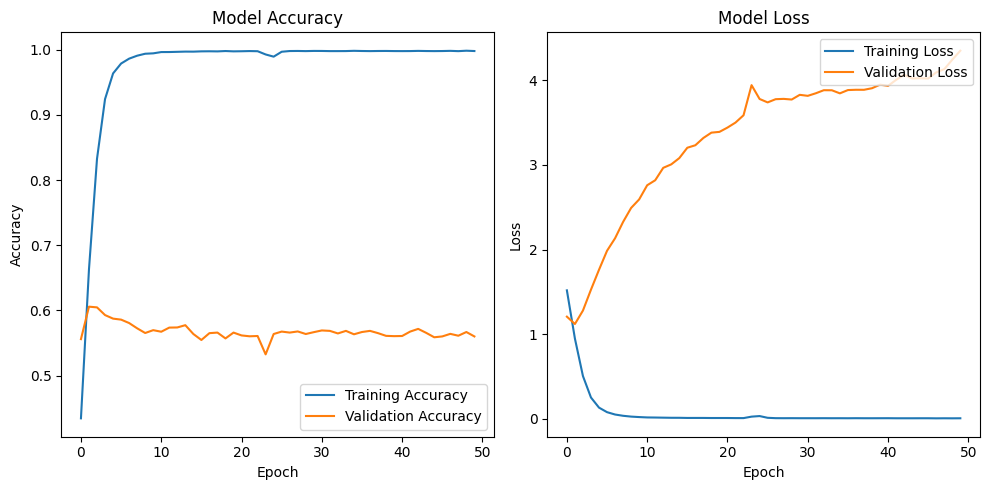

Classification Report:
              precision    recall  f1-score   support

       Anger       0.49      0.44      0.46       711
     Disgust       0.42      0.37      0.39       395
        Fear       0.04      0.04      0.04        45
        Hate       0.84      0.71      0.77       305
         Joy       0.64      0.70      0.67      1593
        Love       0.39      0.41      0.40       462
     Sadness       0.61      0.58      0.60       928
    Surprise       0.19      0.21      0.20       136

    accuracy                           0.56      4575
   macro avg       0.45      0.43      0.44      4575
weighted avg       0.56      0.56      0.56      4575



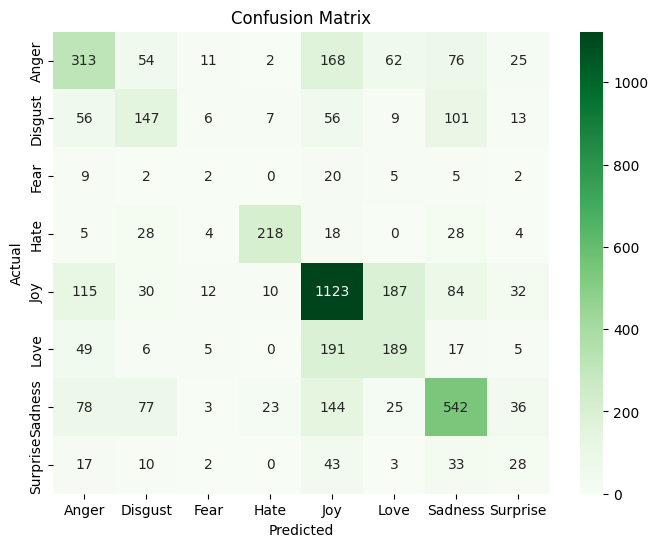

In [ ]:
evaluate_model(model, X_test_padded, y_test, history, label_encoder)

In [ ]:
from keras.models import load_model
cnn_model = load_model('/content/drive/MyDrive/Model/Opu/CNN/best_model_new.h5')

y_pred_prob = cnn_model.predict(X_test_padded)
y_pred = np.argmax(y_pred_prob, axis=1)

y_test_actual = label_encoder.inverse_transform(y_test)
y_pred_actual = label_encoder.inverse_transform(y_pred)

accuracy = accuracy_score(y_test_actual, y_pred_actual)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(y_test_actual, y_pred_actual, average='weighted')
print(f'Precision: {precision:.4f}')

recall = recall_score(y_test_actual, y_pred_actual, average='weighted')
print(f'Recall: {recall:.4f}')

f1 = f1_score(y_test_actual, y_pred_actual, average='weighted')
print(f'F1-Score: {f1:.4f}')

143/143 [==============================] - 1s 4ms/step
Accuracy: 0.6057
Precision: 0.5770
Recall: 0.6057
F1-Score: 0.5830


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#####**Using l2**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
embedding_dim = 128
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(8, activation='softmax', kernel_regularizer=l2(0.01)))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Model/Opu/CNN/best_model_new1.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 conv1d_3 (Conv1D)           (None, 248, 64)           24640     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 124, 64)           0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 7936)              0         
                                                                 
 dense_5 (Dense)             (None, 8)                 63496     
                                                                 
Total params: 5192776 (19.81 MB)
Trainable params: 5192776 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [ ]:
history = model.fit(X_train_padded, y_train, epochs=50, batch_size=64, validation_data=(X_test_padded, y_test), callbacks=[checkpoint])

Epoch 1/50
286/286 [==============================] - ETA: 0s - loss: 1.8026 - accuracy: 0.3969
Epoch 1: val_accuracy improved from -inf to 0.46973, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new1.h5
286/286 [==============================] - 18s 59ms/step - loss: 1.8026 - accuracy: 0.3969 - val_loss: 1.5167 - val_accuracy: 0.4697
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


279/286 [============================>.] - ETA: 0s - loss: 1.4238 - accuracy: 0.5192
Epoch 2: val_accuracy improved from 0.46973 to 0.50885, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new1.h5
286/286 [==============================] - 7s 24ms/step - loss: 1.4257 - accuracy: 0.5187 - val_loss: 1.4609 - val_accuracy: 0.5089
Epoch 3/50
279/286 [============================>.] - ETA: 0s - loss: 1.2909 - accuracy: 0.5879
Epoch 3: val_accuracy did not improve from 0.50885
286/286 [==============================] - 4s 14ms/step - loss: 1.2903 - accuracy: 0.5879 - val_loss: 1.4896 - val_accuracy: 0.4997
Epoch 4/50
282/286 [============================>.] - ETA: 0s - loss: 1.2025 - accuracy: 0.6427
Epoch 4: val_accuracy improved from 0.50885 to 0.52109, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new1.h5
286/286 [==============================] - 4s 16ms/step - loss: 1.2032 - accuracy: 0.6422 - val_loss: 1.5007 - val_accuracy: 0.5211
Epoch 5/50
281/286 [

143/143 [==============================] - 0s 2ms/step
Accuracy: 0.4804
Precision: 0.4810
Recall: 0.4804
F1-Score: 0.4731


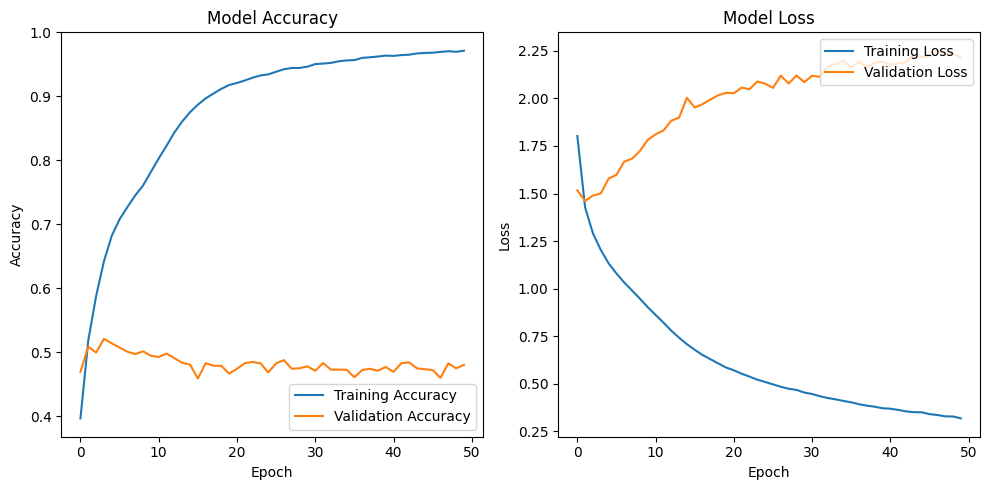

Classification Report:
              precision    recall  f1-score   support

       Anger       0.38      0.29      0.33       711
     Disgust       0.32      0.27      0.29       395
        Fear       1.00      0.02      0.04        45
        Hate       0.74      0.63      0.68       305
         Joy       0.60      0.67      0.64      1593
        Love       0.26      0.35      0.30       462
     Sadness       0.48      0.50      0.49       928
    Surprise       0.04      0.03      0.04       136

    accuracy                           0.48      4575
   macro avg       0.48      0.34      0.35      4575
weighted avg       0.48      0.48      0.47      4575



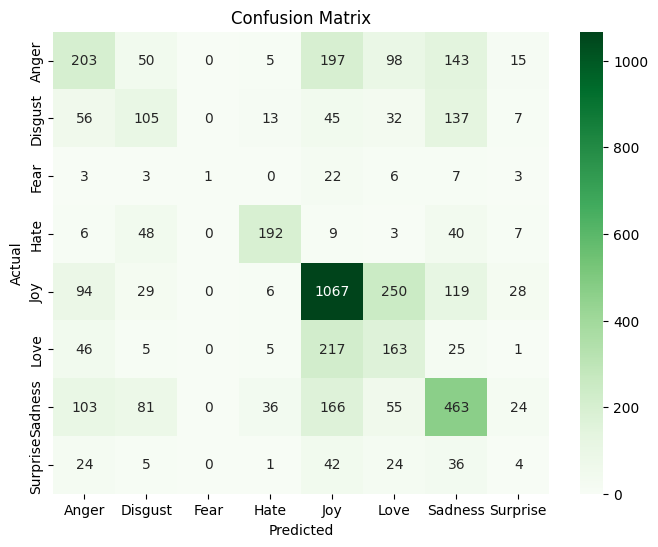

In [ ]:
evaluate_model(model, X_test_padded, y_test, history, label_encoder)

##Oversampling

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, Dense, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/Opu/Emotion.csv")

In [ ]:
df.head()

,ID,Data,Love,Joy,Surprise,Anger,Sadness,Fear,Disgust,Hate,Topic,Domain,is_admin
0,5454.0,লকাল বাস ভালো এটা থেকে,0,0,0.0,0,1,0,0.0,0,Travel,Youtube,False
1,22549.0,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,0,0,0.0,0,1,0,0.0,0,Politics,Youtube,False
2,7033.0,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,0,0,0.0,1,0,0,0.0,0,Personal,Facebook,False
3,21114.0,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,0,0,0.0,0,1,0,0.0,0,Education,Facebook,False
4,23683.0,সত্যিকার মানুষ তারাই ভাই,0,1,0.0,0,0,0,0.0,0,Personal,Youtube,False


In [ ]:
df.drop(columns=['ID', 'Topic', 'Domain', 'is_admin'], inplace=True)

In [ ]:
df.head()

,Data,Love,Joy,Surprise,Anger,Sadness,Fear,Disgust,Hate
0,লকাল বাস ভালো এটা থেকে,0,0,0.0,0,1,0,0.0,0
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,0,0,0.0,0,1,0,0.0,0
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,0,0,0.0,1,0,0,0.0,0
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,0,0,0.0,0,1,0,0.0,0
4,সত্যিকার মানুষ তারাই ভাই,0,1,0.0,0,0,0,0.0,0


In [ ]:
for column in df.columns[1:-1]:
    count = (df[column] == 1).sum()
    print(f"{column}: {count}")

Love: 4588
Joy: 10112
Surprise: 1086
Anger: 4476
Sadness: 5681
Fear: 401
Disgust: 2068


In [ ]:
rows_to_remove = []
df['label'] = None
for index, row in df.iterrows():
    count_ones = 0
    label = None
    for column in df.columns[1:]:
        if row[column] == 1:
            count_ones += 1
            label = column
            if count_ones > 1:
                rows_to_remove.append(index)
                break
    df.loc[index, 'label'] = label

df.drop(rows_to_remove, inplace=True)

In [ ]:
df.head()

,Data,Love,Joy,Surprise,Anger,Sadness,Fear,Disgust,Hate,label
0,লকাল বাস ভালো এটা থেকে,0,0,0.0,0,1,0,0.0,0,Sadness
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,0,0,0.0,0,1,0,0.0,0,Sadness
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,0,0,0.0,1,0,0,0.0,0,Anger
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,0,0,0.0,0,1,0,0.0,0,Sadness
4,সত্যিকার মানুষ তারাই ভাই,0,1,0.0,0,0,0,0.0,0,Joy


In [ ]:
df['label'].value_counts()

label
Joy         7669
Sadness     4856
Anger       3435
Love        2279
Disgust     2068
Hate        1591
Surprise     744
Fear         233
Name: count, dtype: int64

In [ ]:
print('Total Data : ', df['Data'].shape)
print('Total Label : ', df['label'].shape)

Total Data :  (22875,)
Total Label :  (22875,)


####**Remove Unnecessary column**

In [ ]:
df.drop(columns=['Love', 'Joy', 'Surprise', 'Anger','Sadness','Fear','Disgust','Hate'], inplace=True)

In [ ]:
df.head()

,Data,label
0,লকাল বাস ভালো এটা থেকে,Sadness
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,Sadness
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,Anger
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,Sadness
4,সত্যিকার মানুষ তারাই ভাই,Joy


In [ ]:
df['label'].unique()

array(['Sadness', 'Anger', 'Joy', 'Love', 'Surprise', 'Fear', 'Disgust',
       'Hate'], dtype=object)

In [ ]:
import string
import re
def preprocess_text(text):

    text = re.sub('<[^<]+?>', '', text)
    text = re.sub(r'http\S+', '', text)
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = ' '.join([word for word in text.split() if len(word) > 1])
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

df['Data'] = df['Data'].apply(lambda x: preprocess_text(x) if pd.notnull(x) else x)
print(df.head())

                                                Data    label
0                             লকাল বাস ভালো এটা থেকে  Sadness
1  কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...  Sadness
2  বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান নং ...    Anger
3                   চাচাজি তো কেবল মাকে ধর্ষণ করেছেন  Sadness
4                           সত্যিকার মানুষ তারাই ভাই      Joy


In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['Data'] = df['Data'].apply(remove_emoji)
df.head()

,Data,label
0,লকাল বাস ভালো এটা থেকে,Sadness
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,Sadness
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান নং ...,Anger
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,Sadness
4,সত্যিকার মানুষ তারাই ভাই,Joy


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Data'])
vocab_size = len(tokenizer.word_index) + 1
max_sequence_length = max([len(x.split()) for x in df['Data']])

print("Vocabulary size:", vocab_size)
print("Max sequence length:", max_sequence_length)

Vocabulary size: 39880
Max sequence length: 250


In [ ]:
texts = df.drop('label', axis=1)
labels = df['label']
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(texts, labels)
print('Before sampling: ', Counter(labels))
print('After sampling: ', Counter(y_resampled))

Before sampling:  Counter({'Joy': 7669, 'Sadness': 4856, 'Anger': 3435, 'Love': 2279, 'Disgust': 2068, 'Hate': 1591, 'Surprise': 744, 'Fear': 233})
After sampling:  Counter({'Sadness': 7669, 'Anger': 7669, 'Joy': 7669, 'Love': 7669, 'Surprise': 7669, 'Fear': 7669, 'Disgust': 7669, 'Hate': 7669})


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_resampled['Data'])
sequences = tokenizer.texts_to_sequences(X_resampled['Data'])
vocab_size = len(tokenizer.word_index) + 1

X = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
y = LabelEncoder().fit_transform(y_resampled)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(49081, 250) (12271, 250) (49081,) (12271,)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
embedding_dim = 128
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(8, activation='softmax'))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Model/Opu/CNN/best_model_new1.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 conv1d_7 (Conv1D)           (None, 248, 64)           24640     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 124, 64)           0         
 g1D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 7936)              0         
                                                                 
 dense_9 (Dense)             (None, 8)                 63496     
                                                                 
Total params: 5192776 (19.81 MB)
Trainable params: 5192776 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
767/767 [==============================] - ETA: 0s - loss: 0.9739 - accuracy: 0.6408
Epoch 1: val_accuracy improved from -inf to 0.83547, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


767/767 [==============================] - 33s 39ms/step - loss: 0.9739 - accuracy: 0.6408 - val_loss: 0.4752 - val_accuracy: 0.8355
Epoch 2/50
759/767 [============================>.] - ETA: 0s - loss: 0.2437 - accuracy: 0.9201
Epoch 2: val_accuracy improved from 0.83547 to 0.90050, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new1.h5
767/767 [==============================] - 10s 14ms/step - loss: 0.2434 - accuracy: 0.9202 - val_loss: 0.3127 - val_accuracy: 0.9005
Epoch 3/50
763/767 [============================>.] - ETA: 0s - loss: 0.0780 - accuracy: 0.9766
Epoch 3: val_accuracy improved from 0.90050 to 0.91101, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new1.h5
767/767 [==============================] - 6s 8ms/step - loss: 0.0781 - accuracy: 0.9766 - val_loss: 0.3192 - val_accuracy: 0.9110
Epoch 4/50
766/767 [============================>.] - ETA: 0s - loss: 0.0348 - accuracy: 0.9900
Epoch 4: val_accuracy improved from 0.91101 to 0.91207, sav

384/384 [==============================] - 1s 3ms/step
Accuracy: 0.9091
Precision: 0.9068
Recall: 0.9091
F1-Score: 0.9071


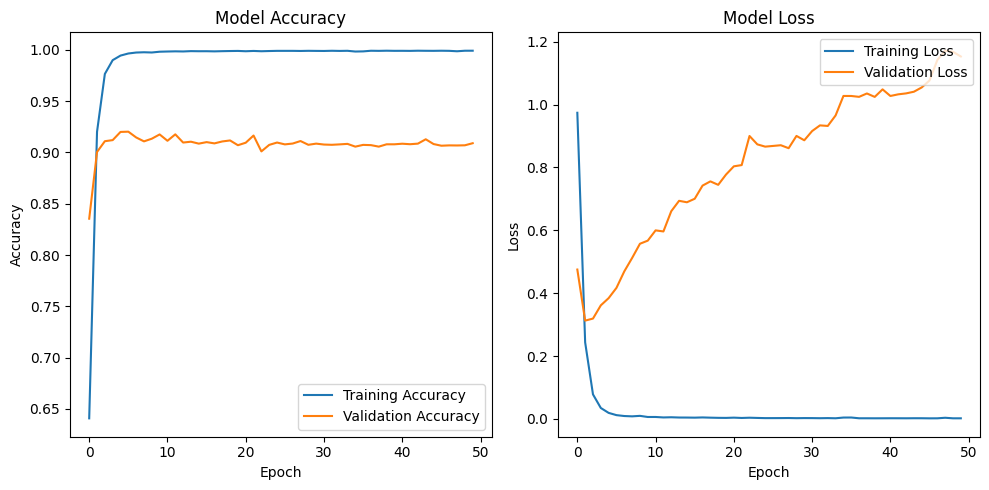

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1510
           1       0.93      0.96      0.94      1530
           2       1.00      1.00      1.00      1532
           3       0.98      1.00      0.99      1527
           4       0.78      0.68      0.73      1541
           5       0.87      0.94      0.91      1560
           6       0.88      0.83      0.85      1514
           7       0.97      1.00      0.98      1557

    accuracy                           0.91     12271
   macro avg       0.91      0.91      0.91     12271
weighted avg       0.91      0.91      0.91     12271



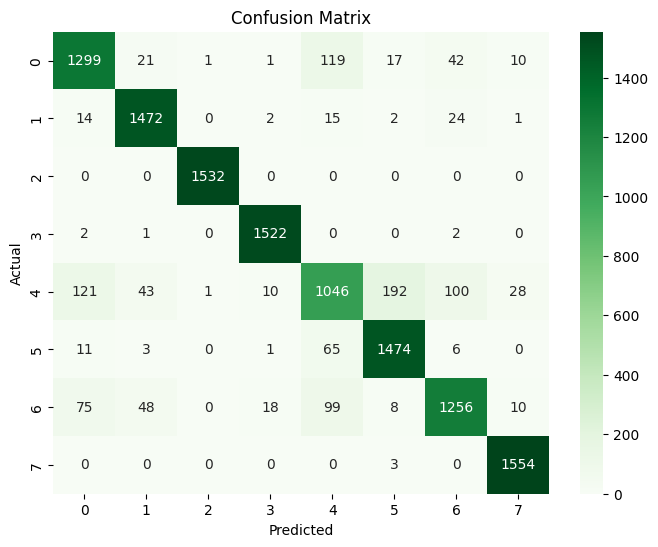

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

'''# Inverse transform encoded labels to actual labels
y_test_actual = label_encoder.inverse_transform(y_test)
y_pred_actual = label_encoder.inverse_transform(y_pred)'''
y_test_actual = y_test
y_pred_actual = y_pred
# Accuracy
accuracy = accuracy_score(y_test_actual, y_pred_actual)
print(f'Accuracy: {accuracy:.4f}')

# Precision
precision = precision_score(y_test_actual, y_pred_actual, average='weighted')
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(y_test_actual, y_pred_actual, average='weighted')
print(f'Recall: {recall:.4f}')

# F1-Score
f1 = f1_score(y_test_actual, y_pred_actual, average='weighted')
print(f'F1-Score: {f1:.4f}')

# Learning Curve
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test_actual, y_pred_actual))

# Confusion Matrix
cm = confusion_matrix(y_test_actual, y_pred_actual)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

# Add labels to the confusion matrix
tick_labels = label_encoder.classes_
plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##**89 With Curve**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
embedding_dim = 128
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(8, activation='softmax', kernel_regularizer=l2(0.01)))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Model/Opu/CNN/best_model_new2.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 250, 128)          5104640   
                                                                 
 conv1d_8 (Conv1D)           (None, 248, 64)           24640     
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 124, 64)           0         
 g1D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 7936)              0         
                                                                 
 dense_10 (Dense)            (None, 8)                 63496     
                                                                 
Total params: 5192776 (19.81 MB)
Trainable params: 5192776 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/50
761/767 [============================>.] - ETA: 0s - loss: 1.6852 - accuracy: 0.4291
Epoch 1: val_accuracy improved from -inf to 0.58569, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new2.h5
767/767 [==============================] - 31s 39ms/step - loss: 1.6823 - accuracy: 0.4306 - val_loss: 1.3442 - val_accuracy: 0.5857
Epoch 2/50
  1/767 [..............................] - ETA: 6s - loss: 1.1876 - accuracy: 0.6250

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


763/767 [============================>.] - ETA: 0s - loss: 1.1316 - accuracy: 0.7137
Epoch 2: val_accuracy improved from 0.58569 to 0.73547, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new2.h5
767/767 [==============================] - 9s 12ms/step - loss: 1.1311 - accuracy: 0.7139 - val_loss: 1.0748 - val_accuracy: 0.7355
Epoch 3/50
762/767 [============================>.] - ETA: 0s - loss: 0.9104 - accuracy: 0.8150
Epoch 3: val_accuracy improved from 0.73547 to 0.78624, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new2.h5
767/767 [==============================] - 7s 9ms/step - loss: 0.9100 - accuracy: 0.8151 - val_loss: 0.9576 - val_accuracy: 0.7862
Epoch 4/50
761/767 [============================>.] - ETA: 0s - loss: 0.7785 - accuracy: 0.8686
Epoch 4: val_accuracy improved from 0.78624 to 0.81509, saving model to /content/drive/MyDrive/Model/Opu/CNN/best_model_new2.h5
767/767 [==============================] - 8s 11ms/step - loss: 0.7786 - acc

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


384/384 [==============================] - 1s 3ms/step
Accuracy: 0.8954
Precision: 0.8930
Recall: 0.8954
F1-Score: 0.8915


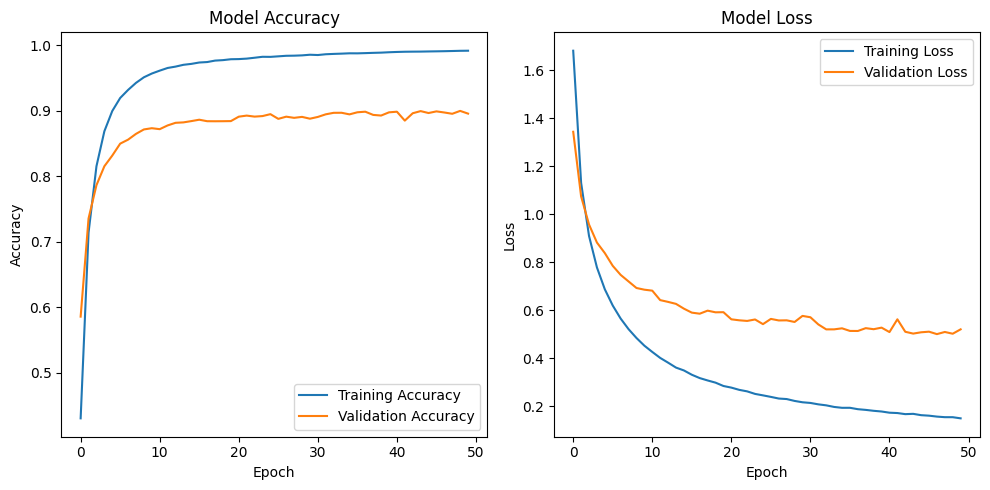

Classification Report:
              precision    recall  f1-score   support

       Angry       0.82      0.88      0.85      1510
     Disgust       0.93      0.96      0.94      1530
        Fear       0.99      1.00      1.00      1532
        Hate       0.99      0.99      0.99      1527
         Joy       0.80      0.59      0.68      1541
        Love       0.84      0.93      0.89      1560
     Sadness       0.83      0.81      0.82      1514
    Surprise       0.93      1.00      0.97      1557

    accuracy                           0.90     12271
   macro avg       0.89      0.90      0.89     12271
weighted avg       0.89      0.90      0.89     12271



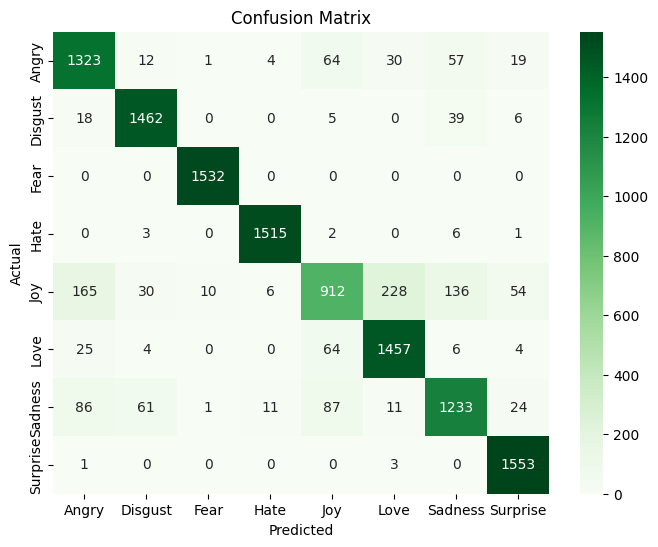

In [ ]:
evaluate_model(model, X_test, y_test, history)

##Hybrid - Oversampling

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, Dense, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/Opu/Emotion.csv")

In [ ]:
df.head()

,ID,Data,Love,Joy,Surprise,Anger,Sadness,Fear,Disgust,Hate,Topic,Domain,is_admin
0,5454.0,লকাল বাস ভালো এটা থেকে,0,0,0.0,0,1,0,0.0,0,Travel,Youtube,False
1,22549.0,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,0,0,0.0,0,1,0,0.0,0,Politics,Youtube,False
2,7033.0,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,0,0,0.0,1,0,0,0.0,0,Personal,Facebook,False
3,21114.0,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,0,0,0.0,0,1,0,0.0,0,Education,Facebook,False
4,23683.0,সত্যিকার মানুষ তারাই ভাই,0,1,0.0,0,0,0,0.0,0,Personal,Youtube,False


In [ ]:
df.drop(columns=['ID', 'Topic', 'Domain', 'is_admin'], inplace=True)

In [ ]:
df.head()

,Data,Love,Joy,Surprise,Anger,Sadness,Fear,Disgust,Hate
0,লকাল বাস ভালো এটা থেকে,0,0,0.0,0,1,0,0.0,0
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,0,0,0.0,0,1,0,0.0,0
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,0,0,0.0,1,0,0,0.0,0
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,0,0,0.0,0,1,0,0.0,0
4,সত্যিকার মানুষ তারাই ভাই,0,1,0.0,0,0,0,0.0,0


In [ ]:
for column in df.columns[1:-1]:
    count = (df[column] == 1).sum()
    print(f"{column}: {count}")

Love: 4588
Joy: 10112
Surprise: 1086
Anger: 4476
Sadness: 5681
Fear: 401
Disgust: 2068


In [ ]:
rows_to_remove = []
df['label'] = None
for index, row in df.iterrows():
    count_ones = 0
    label = None
    for column in df.columns[1:]:
        if row[column] == 1:
            count_ones += 1
            label = column
            if count_ones > 1:
                rows_to_remove.append(index)
                break
    df.loc[index, 'label'] = label

df.drop(rows_to_remove, inplace=True)

In [ ]:
df.head()

,Data,Love,Joy,Surprise,Anger,Sadness,Fear,Disgust,Hate,label
0,লকাল বাস ভালো এটা থেকে,0,0,0.0,0,1,0,0.0,0,Sadness
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,0,0,0.0,0,1,0,0.0,0,Sadness
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,0,0,0.0,1,0,0,0.0,0,Anger
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,0,0,0.0,0,1,0,0.0,0,Sadness
4,সত্যিকার মানুষ তারাই ভাই,0,1,0.0,0,0,0,0.0,0,Joy


In [ ]:
df['label'].value_counts()

label
Joy         7669
Sadness     4856
Anger       3435
Love        2279
Disgust     2068
Hate        1591
Surprise     744
Fear         233
Name: count, dtype: int64

In [ ]:
print('Total Data : ', df['Data'].shape)
print('Total Label : ', df['label'].shape)

Total Data :  (22875,)
Total Label :  (22875,)


####**Remove Unnecessary column**

In [ ]:
df.drop(columns=['Love', 'Joy', 'Surprise', 'Anger','Sadness','Fear','Disgust','Hate'], inplace=True)

In [ ]:
df.head()

,Data,label
0,লকাল বাস ভালো এটা থেকে,Sadness
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,Sadness
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,Anger
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,Sadness
4,সত্যিকার মানুষ তারাই ভাই,Joy


In [ ]:
df['label'].unique()

array(['Sadness', 'Anger', 'Joy', 'Love', 'Surprise', 'Fear', 'Disgust',
       'Hate'], dtype=object)

In [ ]:
import string
import re
def preprocess_text(text):

    text = re.sub('<[^<]+?>', '', text)
    text = re.sub(r'http\S+', '', text)
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = ' '.join([word for word in text.split() if len(word) > 1])
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

df['Data'] = df['Data'].apply(lambda x: preprocess_text(x) if pd.notnull(x) else x)
print(df.head())

                                                Data    label
0                             লকাল বাস ভালো এটা থেকে  Sadness
1  কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...  Sadness
2  বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান নং ...    Anger
3                   চাচাজি তো কেবল মাকে ধর্ষণ করেছেন  Sadness
4                           সত্যিকার মানুষ তারাই ভাই      Joy


In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['Data'] = df['Data'].apply(remove_emoji)
df.head()

,Data,label
0,লকাল বাস ভালো এটা থেকে,Sadness
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,Sadness
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান নং ...,Anger
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,Sadness
4,সত্যিকার মানুষ তারাই ভাই,Joy


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Data'])
vocab_size = len(tokenizer.word_index) + 1
max_sequence_length = max([len(x.split()) for x in df['Data']])

print("Vocabulary size:", vocab_size)
print("Max sequence length:", max_sequence_length)

Vocabulary size: 39880
Max sequence length: 250


In [ ]:
texts = df.drop('label', axis=1)
labels = df['label']
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(texts, labels)
print('Before sampling: ', Counter(labels))
print('After sampling: ', Counter(y_resampled))

Before sampling:  Counter({'Joy': 7669, 'Sadness': 4856, 'Anger': 3435, 'Love': 2279, 'Disgust': 2068, 'Hate': 1591, 'Surprise': 744, 'Fear': 233})
After sampling:  Counter({'Sadness': 7669, 'Anger': 7669, 'Joy': 7669, 'Love': 7669, 'Surprise': 7669, 'Fear': 7669, 'Disgust': 7669, 'Hate': 7669})


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_resampled['Data'])
sequences = tokenizer.texts_to_sequences(X_resampled['Data'])
vocab_size = len(tokenizer.word_index) + 1

X = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
y = LabelEncoder().fit_transform(y_resampled)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(49081, 250) (12271, 250) (49081,) (12271,)


## CNN+LSTM

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Concatenate, concatenate
from keras.callbacks import ModelCheckpoint
embedding_dim = 128

input_shape = (max_sequence_length,)

cnn_input = Input(shape=input_shape)
embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_sequence_length)(cnn_input)
conv1 = Conv1D(128, 5, activation='relu')(embedding_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
flatten1 = Flatten()(pool1)

lstm_input = Input(shape=input_shape)
embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_sequence_length)(lstm_input)
lstm = LSTM(128)(embedding_layer)

merged = concatenate([flatten1, lstm])

dense_layer = Dense(128, activation='relu')(merged)
output = Dense(8, activation='softmax')(dense_layer)

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model = Model(inputs=[cnn_input, lstm_input], outputs=output)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Model/Opu/CNN/hybrid_oversampling.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 250)]                0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 250, 128)             5104640   ['input_11[0][0]']            
                                                                                                  
 conv1d_6 (Conv1D)           (None, 246, 128)             82048     ['embedding_10[0][0]']        
                                                                                                  
 input_12 (InputLayer)       [(None, 250)]                0         []                            
                                                                                            

In [ ]:
history = model.fit([X_train, X_train], y_train, epochs=50, batch_size=64, validation_data=([X_test, X_test], y_test), callbacks=[checkpoint])

Epoch 1/50
767/767 [==============================] - ETA: 0s - loss: 0.9083 - accuracy: 0.6564
Epoch 1: val_accuracy improved from -inf to 0.85429, saving model to /content/drive/MyDrive/Model/Opu/CNN/hybrid_oversampling.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


767/767 [==============================] - 66s 82ms/step - loss: 0.9083 - accuracy: 0.6564 - val_loss: 0.4206 - val_accuracy: 0.8543
Epoch 2/50
765/767 [============================>.] - ETA: 0s - loss: 0.2025 - accuracy: 0.9321
Epoch 2: val_accuracy improved from 0.85429 to 0.90751, saving model to /content/drive/MyDrive/Model/Opu/CNN/hybrid_oversampling.h5
767/767 [==============================] - 23s 30ms/step - loss: 0.2025 - accuracy: 0.9321 - val_loss: 0.3031 - val_accuracy: 0.9075
Epoch 3/50
766/767 [============================>.] - ETA: 0s - loss: 0.0575 - accuracy: 0.9819
Epoch 3: val_accuracy improved from 0.90751 to 0.91394, saving model to /content/drive/MyDrive/Model/Opu/CNN/hybrid_oversampling.h5
767/767 [==============================] - 30s 39ms/step - loss: 0.0575 - accuracy: 0.9819 - val_loss: 0.3450 - val_accuracy: 0.9139
Epoch 4/50
766/767 [============================>.] - ETA: 0s - loss: 0.0225 - accuracy: 0.9931
Epoch 4: val_accuracy did not improve from 0.9139

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, history):
    class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']

    # Predictions
    y_pred_prob = model.predict([X_test, X_test])
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall: {recall:.4f}')

    # F1-Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1-Score: {f1:.4f}')

    # Learning Curve
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')

    # Add labels to the confusion matrix
    tick_labels = class_names
    plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

384/384 [==============================] - 5s 6ms/step
Accuracy: 0.9108
Precision: 0.9091
Recall: 0.9108
F1-Score: 0.9089


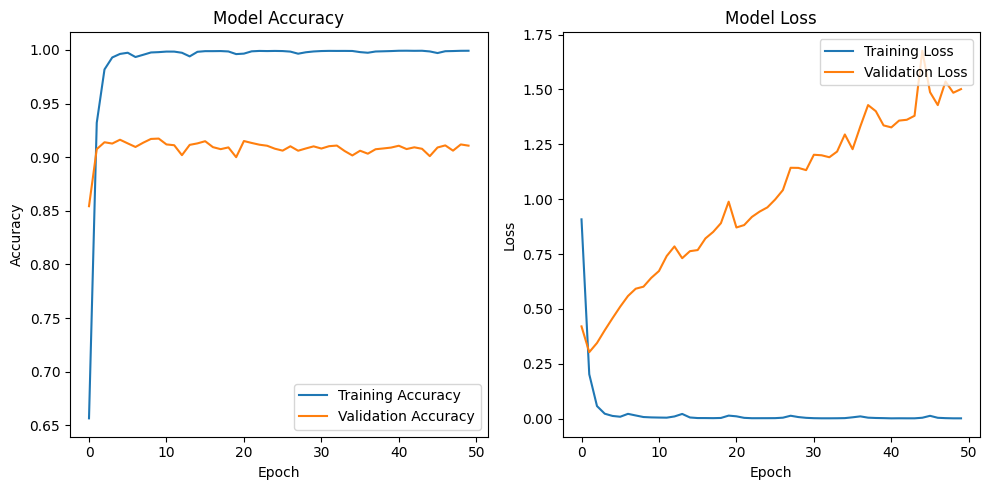

Classification Report:
              precision    recall  f1-score   support

       Angry       0.82      0.88      0.85      1510
     Disgust       0.93      0.96      0.95      1530
        Fear       1.00      1.00      1.00      1532
        Hate       0.99      1.00      0.99      1527
         Joy       0.80      0.69      0.74      1541
        Love       0.89      0.94      0.91      1560
     Sadness       0.87      0.80      0.84      1514
    Surprise       0.97      1.00      0.98      1557

    accuracy                           0.91     12271
   macro avg       0.91      0.91      0.91     12271
weighted avg       0.91      0.91      0.91     12271



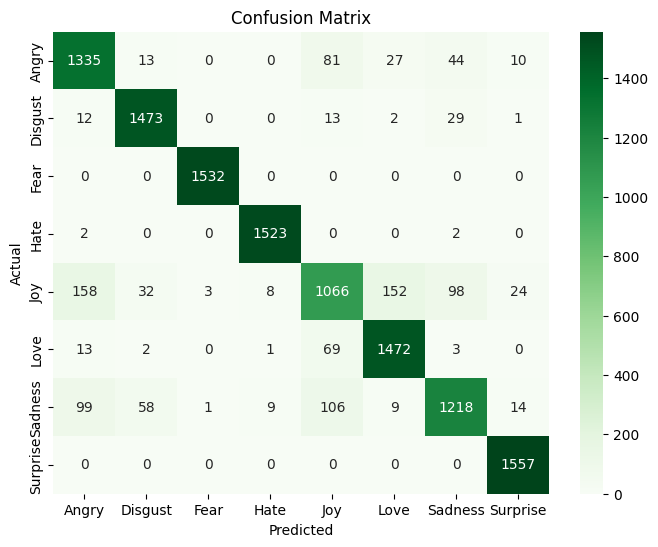

In [ ]:
evaluate_model(model, X_test, y_test, history)

384/384 [==============================] - 9s 24ms/step


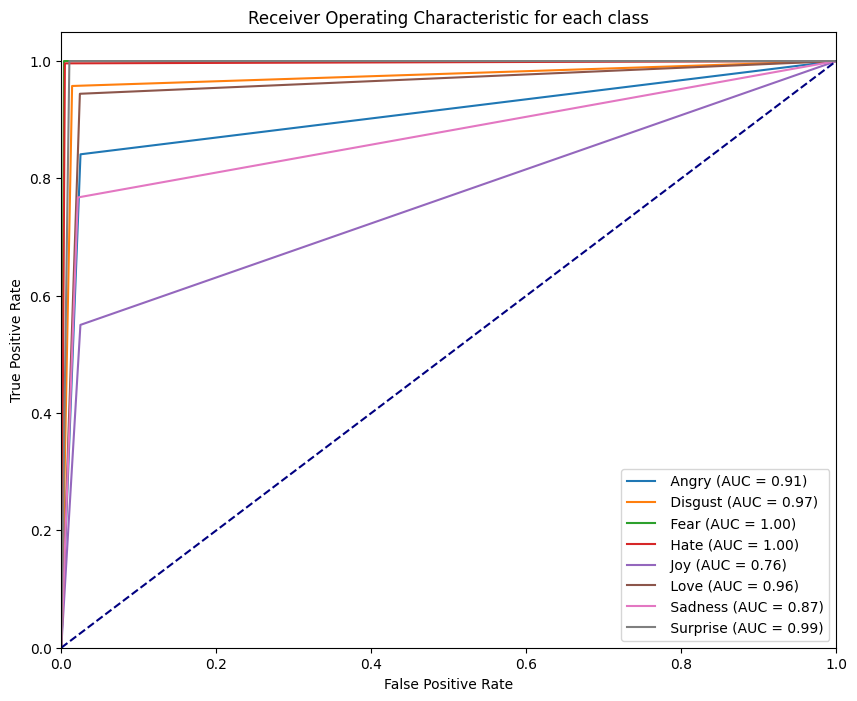

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
class_names = ['Angry', 'Disgust', 'Fear', 'Hate', 'Joy', 'Love', 'Sadness', 'Surprise']
y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f' {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()

384/384 [==============================] - 8s 21ms/step


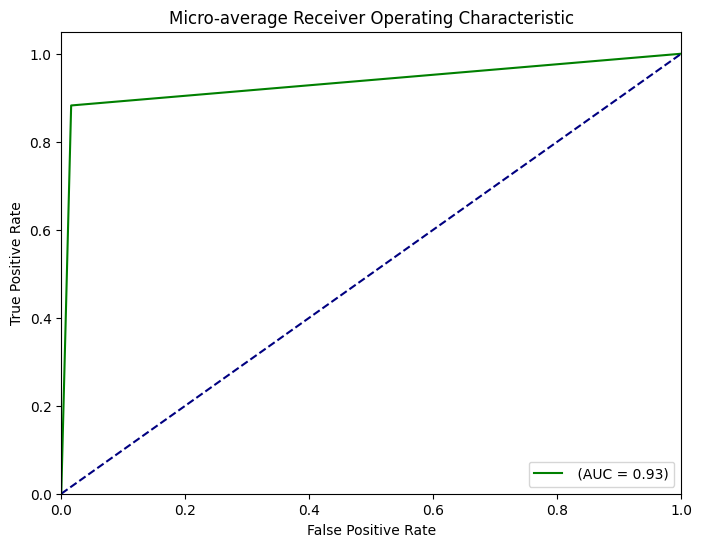

AUC =  0.9332339895456186


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))